# Quantum Mechanics Tools
## Section 4: Computation of standard redox potentials

__Questions__

How can you calculate the redox potential of a reaction?

__Objectives__

Perform geometry optimization calculations.

Perform frequency calculations.

Calculate the free energy correction from the frequencies.

### Overview

One of the most important research problems in chemistry is to find efficient ways to accomplish reactions such as CO2 reduction or water splitting that make chemical fuels from electricity. If this could be accomplished efficiently and inexpensively, we would be one step further on the way to a renewable energy economy.

The redox potential is a molecular property in chemistry that is very important for renewable energy problems. It measures the tendency of a species to gain or lose electrons in solution. In order to apply computational chemistry to renewable energy problems, being able to compute redox potentials for molecular species is incredibly important.

In order to compute a redox potential, it is important to understand the basic physical principles of this quantity. For example, take this half-reaction that involves the nitrobenzene molecule:


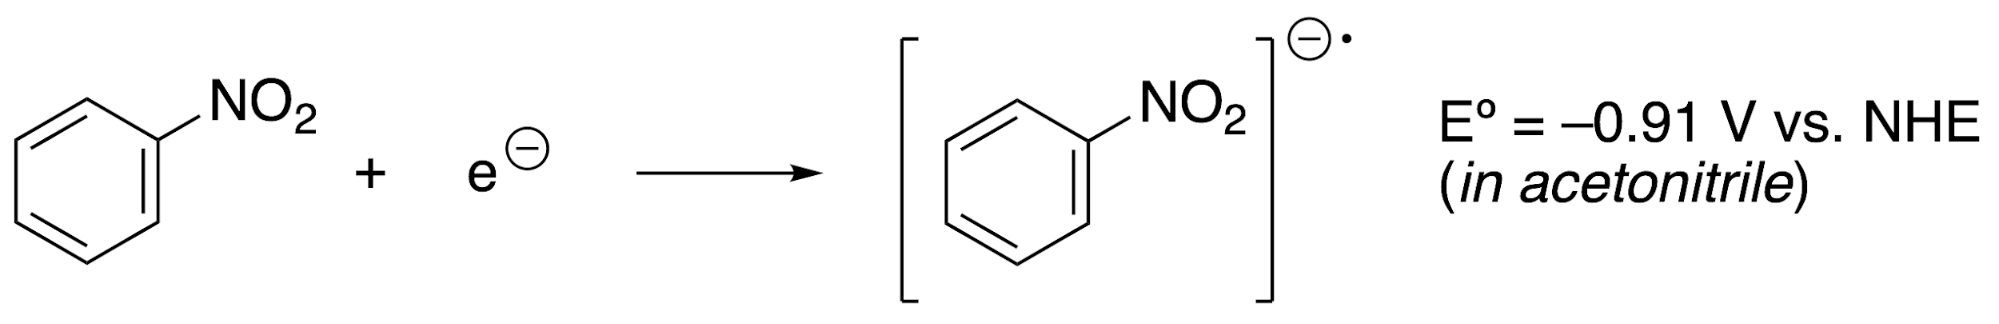





This redox potential measures the tendency of nitrobenzene to gain an electron to produce nitrobenzene radical anion. More negative values of Eº mean that the species is less likely to gain electrons, or that it requires more energy to reduce. To make a comparison, consider this redox half-reaction that involves acetophenone:

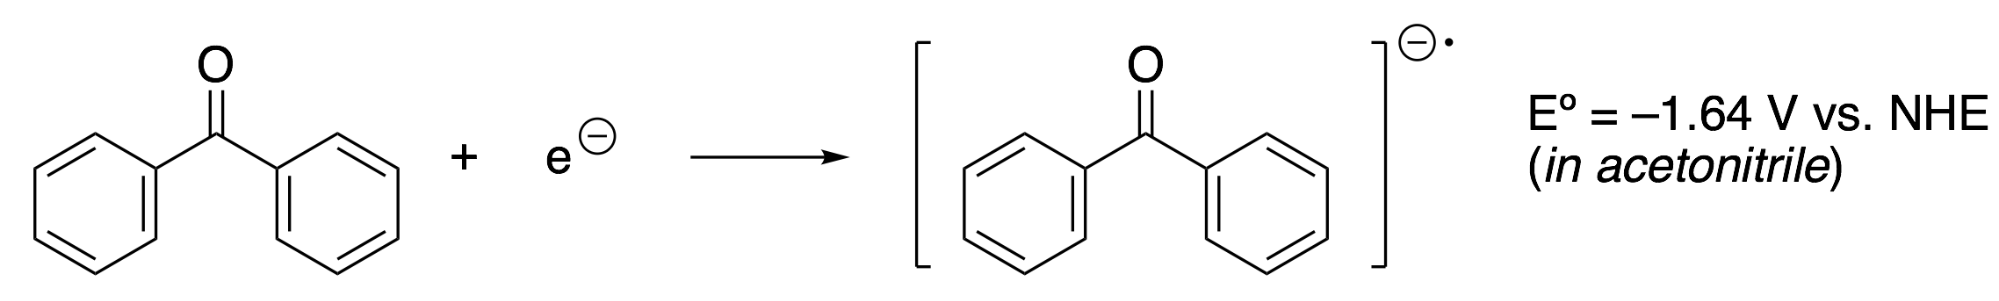

The more negative Eº shows that acetophenone requires more energy to reduce compared to nitrobenzene. Alternatively, acetophenone radical anion would spontaneously transfer an electron to nitrobenzene if they were combined. In this process, __the Gibbs free energy of the reaction is obtained by subtracting the redox potentials and multiplying by the number of electrons, in this case, ∆G = –0.73 eV per molecule, or –17 kcal/mol.__

Going back to our individual half-reactions, the redox potential is related to the Gibbs free energy of the half reaction as:



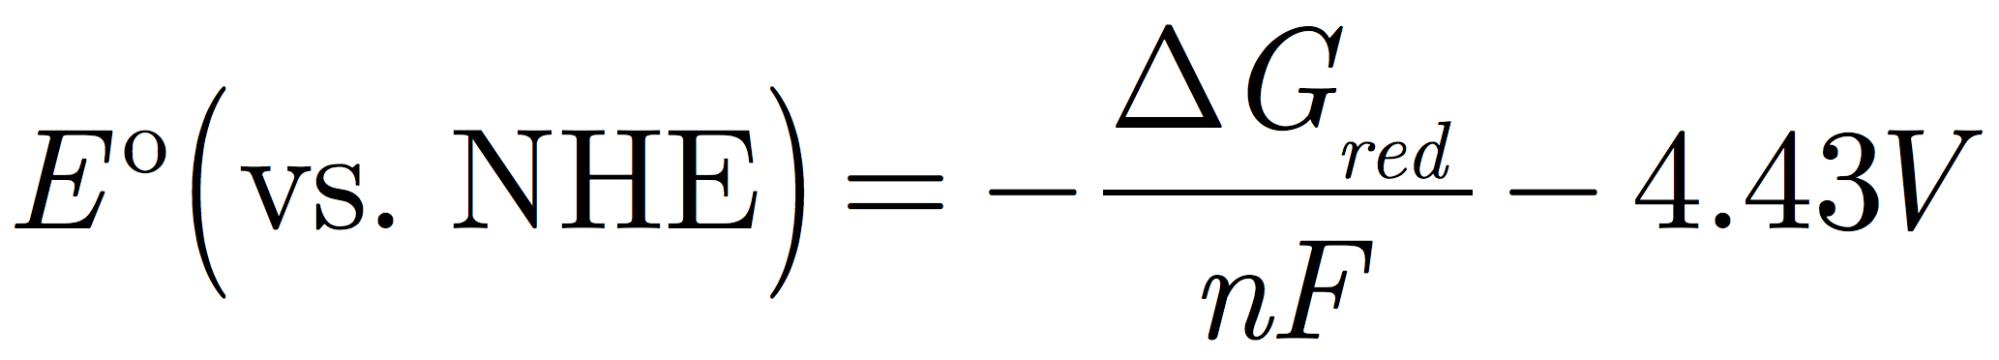




Here, Eº is the redox potential corresponding to the quantity that the experiment measures. This is the potential (voltage) of an electrode surface where reactant and product are in equilibrium. More negative potentials correspond to higher energy electrons needed to reduce the reactant.

G is the free energy change of the reduction half-reaction in solution, where the electron comes from the vacuum, and the molecules are in solution. n is the number of electrons transferred (in our case, n = 1) and F is the Faraday constant; its value is exactly 1 eV/V and serves to convert units of energy (in eV) into units of potential (V).

The electrons in the experiment do not come from vacuum, but from an electrode whose potential is measured relative to a reference electrode. We choose to use the normal hydrogen electrode as a reference, where the energy of the electrons is –4.43 V relative to the vacuum, thus we subtract this value from our answer.

Now that we have seen the physical principles, we’d like to obtain computationally and this would allow us to predict a redox potential. is the Gibbs free energy of reduction, and can be computed as a free energy difference: where G(●) is the Gibbs free energy of a species in solution. Computationally, this is broken down into several contributions:

The first two terms and represent the ground-state electronic energy plus the solvation free energy term. These two terms are computed together as the ground-state energy when running a Psi4 energy calculation in implicit solvent. The equilibrium (minimum energy) structure should be used, but you don’t necessarily need to use implicit solvent, or even the same functional or basis set to perform the minimization, as long as you remain consistent for the oxidized and reduced species.

H – TS represent the enthalpy and entropy terms in the Gibbs free energy. We will approximate these terms by treating the molecule as having three translational and three rotational degrees of freedom, and represent all of the internal motions using harmonic oscillators. The translational contributions to H and S come from known formulas for the ideal gas, the rotational contributions use a rigid rotor approximation that takes information from the molecular geometry, and the vibrational contribution requires a harmonic frequency calculation (including the zero point vibration). The frequency analysis calculation in Psi4 provides all of this information.

### Summary of the calculation procedure

In summary, here are the steps for computing the redox potential:

1. For the neutral molecule, follow these steps to compute the Gibbs free energy:

    Calculate an energy minimized structure.

    Calculate the harmonic free energy correction at the energy minimized structure.

    Calculate the ground state energy plus ∆Gsolv from implicit solvent. (Part (c) may be done at a higher level of     theory than (a) and (b)).

    Add the results from (b) and (c) to get the free energy of the species.
    
2. Repeat the above steps for the anion radical.

3. Calculate ∆Gred = G(A–) – G(A). This should be a negative number because most molecules in solvent are able to accommodate an additional electron.

4. Convert this energy to eV by multiplying your quantity (in a.u.) by 27.211.

5. Multiply by –1 and subtract 4.43 to obtain the redox potential w/r.t. NHE.

In this exercise, we will study neutral nitrobenzene and the nitrobenzene anion to calculate the redox potential.

### Part A: Initial molecule specification and optimizations

Import the require python modules.

In [1]:
import psi4
import numpy as np

In [ ]:
# Set up the calculation options for the initial energy calculation.

psi4.set_memory('2 GB')
psi4.set_num_threads(2)

nitrobenz = psi4.geometry("""
symmetry c1
0 1
C       -3.5048225421    0.0711805817    0.1456897967
C       -2.1242069042    0.0676957680    0.1437250554
C       -1.4565144627    1.2657898054    0.0112805274
C       -2.1243502782    2.4616659201   -0.1394727314
C       -3.5049153121    2.4578370923   -0.1457245349
C       -4.1936081427    1.2645153194    0.0001955136
H       -4.0381801262   -0.8505059514    0.2559173303
H       -1.5620288767   -0.8346363876    0.2389155097
H       -1.5619534389    3.3630228735   -0.2428628637
H       -4.0382012347    3.3785626398   -0.2639829256
H       -5.2650389640    1.2641688843   -0.0022762561
N       -0.0085078655    1.2648596634   -0.0056641832
O        0.5639468379    0.1670702678   -0.1297708787
O        0.5668300231    2.3598431617    0.1306822195
""")

psi4.set_output_file('00_initial_energy.dat', False)
psi4.energy('B3LYP/3-21G')

### Part B: Geometry optimization (gas phase)

In [ ]:
psi4.set_output_file('01_geometry_optimization.dat', False)
psi4.set_options({'g_convergence': 'gau_tight'}) # this forces the optimizer to get close to the minimum
psi4.optimize('B3LYP/3-21G', molecule=nitrobenz)

### Part C: Frequency calculation

In [ ]:
psi4.set_output_file('02_frequency_analysis.dat', False)
b3lyp_321g_energy, b3lyp_321g_wfn = psi4.frequency('B3LYP/3-21G', molecule=nitrobenz, 
                                                   return_wfn=True, dertype='gradient')

In [ ]:
#We have to define a function called parse_free_energy to extract the free energy from the output file.

def parse_free_energy(filename):
    """ Parse out the free energy from a Psi4 vibrational analysis output file in a.u. """
    for line in open(filename).readlines():
        if "Correction G" in line:
            return float(line.split()[-2])
        
parse_free_energy('02_frequency_analysis.dat')

### Part D: Energy calculation with large basis set + PCM solvent model

In [ ]:
psi4.set_options({
  'pcm': True,
  'pcm_scf_type': 'total',
})

psi4.pcm_helper("""
   Units = Angstrom
   Medium {
   SolverType = CPCM
   Solvent = Acetonitrile
   }
   Cavity {
   RadiiSet = UFF
   Type = GePol
   Scaling = False
   Area = 0.3
   Mode = Implicit
   }
""")

psi4.set_output_file('03_solvent_energy.dat', False)
psi4.energy('B3LYP/heavy-aug-cc-pVDZ', molecule=nitrobenz)

#### Exercise: The nitrobenzene anion

Using the commands you already learned, calculate all the same quantities for the reduced nitrobenzene (-1 charge). In your molecule specification section, you will need to change your charge and multiplicity to reflect the correct values for the anion. If you already carried out calculations on the neutral molecule in this notebook, you will need to start a new notebook or click Kernel -> Restart & Clear Output before working on the anion. For the anion calculations, you need to change the refernce using the command psi4.set_options({'reference':'UKS'}) which should be placed right before the energy call.

In [2]:
# part A
psi4.set_memory('2 GB')
psi4.set_num_threads(2)

nitrobenz_anion = psi4.geometry("""
symmetry c1
-1 2
C       -3.5048225421    0.0711805817    0.1456897967
C       -2.1242069042    0.0676957680    0.1437250554
C       -1.4565144627    1.2657898054    0.0112805274
C       -2.1243502782    2.4616659201   -0.1394727314
C       -3.5049153121    2.4578370923   -0.1457245349
C       -4.1936081427    1.2645153194    0.0001955136
H       -4.0381801262   -0.8505059514    0.2559173303
H       -1.5620288767   -0.8346363876    0.2389155097
H       -1.5619534389    3.3630228735   -0.2428628637
H       -4.0382012347    3.3785626398   -0.2639829256
H       -5.2650389640    1.2641688843   -0.0022762561
N       -0.0085078655    1.2648596634   -0.0056641832
O        0.5639468379    0.1670702678   -0.1297708787
O        0.5668300231    2.3598431617    0.1306822195
""")

psi4.set_options({'reference':'UKS'})
psi4.set_output_file('00_initial_energy_anion.dat', False)
psi4.energy('B3LYP/3-21G')

-434.3116167063514

In [3]:
# part B
psi4.set_output_file('01_geometry_optimization_anion.dat', False)
psi4.set_options({'g_convergence': 'gau_tight'})  # this forces the optimizer to get close to the minimum
psi4.optimize('B3LYP/3-21G', molecule=nitrobenz_anion)

Optimizer: Optimization complete!


-434.3388741830241

In [4]:
#part C
psi4.set_output_file('02_frequency_analysis_anion.dat', False)
b3lyp_321g_energy, b3lyp_321g_wfn = psi4.frequency('B3LYP/3-21G', molecule=nitrobenz_anion, 
                                                   return_wfn=True, dertype='gradient')

#We have to define a function called parse_free_energy to extract the free energy from the output file.

def parse_free_energy(filename):
    """ Parse out the free energy from a Psi4 vibrational analysis output file in a.u. """
    for line in open(filename).readlines():
        if "Correction G" in line:
            return float(line.split()[-2])
        
parse_free_energy('02_frequency_analysis_anion.dat')

 73 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 '492.0167' '516.4516' '596.5885']


0.06802182

In [5]:
# part D
psi4.set_options({
  'pcm': True,
  'pcm_scf_type': 'total',
})

psi4.pcm_helper("""
   Units = Angstrom
   Medium {
   SolverType = CPCM
   Solvent = Acetonitrile
   }
   Cavity {
   RadiiSet = UFF
   Type = GePol
   Scaling = False
   Area = 0.3
   Mode = Implicit
   }
""")

psi4.set_output_file('03_solvent_energy_anion.dat', False)
psi4.energy('B3LYP/heavy-aug-cc-pVDZ', molecule=nitrobenz_anion)

-436.9429235419397

Your final results should be as follows.

Charge	  Minimized E (gas)	  Free energy correction (gas)	     SCF E + Delta G Solvation	Total Gibbs Free Energy

0 (oxidized)	-434.317549	            0.071346	                -436.813669	              -436.74232254

-1 (reduced)	-434.338874	            0.068022	                -436.942923	            -436.874901
 	 	 	 	 
To calculate E standard

∆Gred = -436.874901+436.74232254 = -0.13257846 a.u. = -3.607645 eV

-∆Gred / nF = 3.607645 V

Eº = -∆Gred / nF - 4.43 V = -0.82 V

### Further Reading
You can read more on computation of redox potentials using implicit and explicit solvent models here.

https://pubs.acs.org/doi/10.1021/ct200340x

### Key Points

The overall redox potential energy should be between -1 and -10 eV.

The free energy of a radical anion should be more negative than the neutral molecule.


In [9]:
# part b free energy =  -434.3175493737249 --> line 8197
# from part c, correction G  =   0.07134757

#neutral 0 (oxidized): 
#E_gas_neutral = -434.3175493737249
G_correction_gas_neutral = 0.07134757
G_solvent_neutral = -436.8136698155245767
total_G_neutral = G_solvent_neutral + G_correction_gas_neutral

#anion -1 (reduced):
#E_gas_anion = -434.3388741830241
G_correction_gas_anion = 0.06802182
G_solvent_anion = -436.9429235419397
total_G_anion = G_solvent_anion + G_correction_gas_anion

# delta g of reduction (negtive #), convert to ev, mutiply by -1, subtract -4.43:
G_red = ((total_G_anion - total_G_neutral) * -27.211 ) - 4.43

print(f'The redox potential w.r.t NHE for nitrobenzene is {G_red:.2f} V')

The redox potential w.r.t NHE for nitrobenzene is -0.82 V


for the github totiral, I skiped this since I did it already here:
https://education.molssi.org/qm-tools/06-github/index.html

go the next section, restart the notebook and jump to 

### Understand the script 

Methane-VibFreqAnalysis.py is a Python script that contains (surprise, surprise!) the beginnings of a vibrational frequency analysis of methane. In a change from Activity #4, the frequencies are accessed directly using the frequency_analyis method of the wavefunction object. In the script you’ll see a line containing the following code:

print(scf_wfn.frequency_analysis)

This statement causes all of the info generated by the frequency_analyis method to be output to the screen. __Changing the code here will be the “departure point” for this activity.__

Up until this point, we’ve been doing a lot of coding in jupyter notebooks. They have the advantage that you can write code interactively, but sometimes we want to make “traditional” scripts or programs that run from start to finish. Here you have two options for running the code:

Option #1 From a command prompt inside the folder, run the script using the command: python Methane-VibFreqAnalysis.py
The script will run and the print command mentioned above will result in the vibrational frequency information being printed to the screen.

Option #2 You may paste the script into the notebook and run it. It’s best to organize things as:
Cell 1: Import statements Cell 2: Basic setup (e.g., molecular geometry) Cell 3: The rest of the code (running the calculation)

When you execute the cells the vibrational frequency information will be displayed in the notebook.

### Modifying the Script

You will modify the Psi4 script to carry out the vibrational frequency analysis, extract the unique non-zero frequencies and their degeneracies, and save this information to a text file.

The cool thing about PsiAPI is that your quantum chemistry calculation is inside of the Python script, so you have a lot of flexibility to customize it. Once again you may use the jupyter notebook to help develop your code, but ultimately we want it to be part of the Python script.

The first part of the code imports the required python modules, sets up your molecule (methane), and performs a geometry optimization calculation.

In [1]:
import psi4
import numpy as np

# Initial setup
psi4.set_memory('2 GB')
psi4.set_num_threads(2)

file_prefix = 'methane_HF-DZ'

ch4 = psi4.geometry("""
symmetry c1
0 1
   C       -0.85972        2.41258        0.00000
   H        0.21028        2.41258        0.00000
   H       -1.21638        2.69390       -0.96879
   H       -1.21639        3.11091        0.72802
   H       -1.21639        1.43293        0.24076
""")


# Geometry optimization
psi4.set_output_file(file_prefix + '_geomopt.dat', False)
psi4.set_options({'g_convergence': 'gau_tight'})
psi4.optimize('scf/cc-pVDZ', molecule=ch4)

Optimizer: Optimization complete!


-40.19871710397603

The next section runs a frequency calculation.

In [2]:
# Run vibrational frequency analysis
psi4.set_output_file(file_prefix + '_vibfreq.dat', False)
scf_energy, scf_wfn = psi4.frequency('scf/cc-pVDZ', molecule=ch4, return_wfn=True, dertype='gradient')

 19 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


This command outputs the energy to the variable scf_energy and saves the wavefunction as the variable scf_wfn. You can now do other things using that wavefunction object. As discussed above, first we will use the frequency analysis command to print everything associated from the frequency analysis.

In [5]:
print(scf_wfn.frequency_analysis)

{'q': QCAspect(lbl='normal mode', units='a0 u^1/2', data=array([[ 8.57783972e-01, -6.25146078e-02, -6.52142304e-02,
         3.26847062e-02,  1.79249698e-02,  5.64956845e-02,
        -2.75600688e-01,  5.59098930e-02, -2.80488530e-01,
         2.11183599e-07,  4.42667457e-07,  2.78979092e-05,
         1.16792369e-02,  2.19080752e-02, -3.05110618e-01],
       [ 3.11979536e-02,  6.64288015e-02,  6.65425092e-01,
        -6.78268391e-02,  4.80492497e-01,  2.54726323e-01,
         1.59521589e-01, -2.93254244e-01, -2.15195842e-01,
        -3.71639440e-06,  2.79683235e-06, -1.85649232e-07,
        -2.55134758e-01,  1.69146346e-01,  2.37875623e-03],
       [-9.49530383e-02, -9.66676492e-02, -3.54372205e-01,
         3.01848449e-01,  1.86046166e-01,  6.92004072e-01,
         2.37385906e-01,  2.61974782e-01, -1.81029690e-01,
         4.39056358e-06,  3.16899465e-06, -6.31648810e-06,
        -1.68759797e-01, -2.54202961e-01, -2.47125739e-02],
       [ 2.48587885e-01, -1.81169521e-02, -1.88982318e-

Study the full output of this command. The scf_wfn.frequency_analysis generates a dictionary containing all of the vibrational frequency information. (Here’s a quick refresher about dictionaries.) The vibrational frequencies (in cm-1) are contained in the entry omega, which itself is a special type of Python object (for Psi4) called “QCAspect”. Practically speaking, you can treat this object like a list or tuple, and you will find the frequencies as one of the entries within this object. Hint: Use square bracket notation!

For the next Exercises, all of these features can be implemented using functions from the NumPy library, and we highly encourage you to make use of Google/your favorite search engine or the NumPy documentation to find the necessary/useful functions.

### Exercise: Extract the frequencies from the dictionary to a variable

Save the frequencies as a variable called rawfreq.

In [47]:
rawfreq = scf_wfn.frequency_analysis['omega'][2]
print(rawfreq)

[0.00000000e+00+6.08125522e-05j 0.00000000e+00+2.80237094e-05j
 0.00000000e+00+2.04169830e-05j 4.45938553e-06+0.00000000e+00j
 2.54885571e-05+0.00000000e+00j 2.85971301e-05+0.00000000e+00j
 1.43381294e+03+0.00000000e+00j 1.43381472e+03+0.00000000e+00j
 1.43381754e+03+0.00000000e+00j 1.64835126e+03+0.00000000e+00j
 1.64835303e+03+0.00000000e+00j 3.16483499e+03+0.00000000e+00j
 3.28564703e+03+0.00000000e+00j 3.28565355e+03+0.00000000e+00j
 3.28566896e+03+0.00000000e+00j]


### Exercise: Round the real frequencies

Eliminate imaginary parts of frequencies, round the frequencies (to the nearest whole number), and extract only the non-zero frequencies.

In [74]:
real_freq = []
for i in rawfreq:
    if i > 1:
        real = i.real.round()
        real_freq.append(real)

print(real_freq)
# their cleaner solution lol

roundnzfreq = np.round(np.real(rawfreq))[6:]
print(roundnzfreq)
# The slice [6:] is used because for a minimum energy structure the first six frequencies will always be zero, 
#as they represent the translational and rotational degrees of freedom.    

[1434.0, 1434.0, 1434.0, 1648.0, 1648.0, 3165.0, 3286.0, 3286.0, 3286.0]
[1434. 1434. 1434. 1648. 1648. 3165. 3286. 3286. 3286.]


### Exercise: Determine unique frequencies and degeneracies

Determine the unique non-zero frequencies and the number of times each such frequency occurs. Store these in a NumPy array in the format: {frequency, count}, one line per frequency.

In [81]:
freqlist = np.array(np.unique(roundnzfreq, return_counts=True)).T
print(freqlist)

[[1.434e+03 3.000e+00]
 [1.648e+03 2.000e+00]
 [3.165e+03 1.000e+00]
 [3.286e+03 3.000e+00]]


Note that np.unique() will generate two 1D NumPy arrays as called. Enclosing that command with np.array() creates the 2D numpy array. The .T is an easy way to transpose any numpy array.

### Exercise: Save your results to a file.

Save the NumPy array with frequency and count data to a text file.

In [96]:
np.savetxt('methane_freqlist.txt',freqlist, fmt='%0.1f,%d', delimiter=',', header = 'freq,degenrcy')

Here we’ve done a couple of nice things: (1) formatted the frequencies as floats with one decimal place and the degeneracies as integers; (2) included a header line so that other users will understand what’s in the file. If you look in the folder where you ran the script, you should see a file called methane_Freqlist.dat which contains all your data neatly formatted.